#prediction for humor scoring

In [ ]:
model_name_or_path = 'bert-base-uncased'

In [ ]:
# connect to GPU
!nvidia-smi

Sat Feb  6 14:20:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NLP_Project_Humor_Offensive

/content/drive/MyDrive/NLP_Project_Humor_Offensive


## install and import libraries

In [ ]:
 !pip install transformers==3.5.1

     |████████████████████████████████| 1.3MB 9.0MB/s 
     |████████████████████████████████| 1.1MB 35.2MB/s 
     |████████████████████████████████| 890kB 36.2MB/s 
     |████████████████████████████████| 2.9MB 55.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=84fc988d6cf73390057650b2599dc46d197bda969f8826907789a67ced1d2d4d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer
import torch

import numpy as np
import pandas as pd

## check whether connected to gpu

In [ ]:
# determine the gpu for allocating tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

1

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained(model_name_or_path,do_lower_case=True)

## load data
1/8 of train data considered as test data

In [ ]:
# Load train data
data = pd.read_csv('data/train/train.csv')
data['humor_rating'] = data['humor_rating'].fillna(0)
# isHum_train_data = train_data.drop(['humor_rating','humor_controversy','offense_rating'], axis=1, inplace=False)
# print(isHum_train_data.head())
# print(isHum_train_data.describe())
train_data = data[0:7000]
val_data = data[7000:8000]

In [ ]:
print(len(train_data))

7000


In [ ]:
sentences = train_data['text'].values
labels = train_data['humor_rating'].values

In [ ]:
labels

array([2.42, 2.5 , 1.95, ..., 0.  , 0.  , 0.  ])

## prepare data: encodeing and padding

In [ ]:
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit...
Token IDs: tensor([ 101, 5298, 1024, 2057, 1005, 2128, 1996, 2190, 2110, 1012, 6343, 2130,
        3310, 2485, 1012, 1008, 5408, 2791, 4402, 7365, 2046, 1996, 2282, 1008,
        5298, 1024, 2821, 4485, 1012, 1012, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


## consider 90% of data for training

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,300 training samples
  700 validation samples


## manage memory

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# train_dataset = TensorDataset(input_ids, attention_masks, labels)
# val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
 
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model = model.double()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## fintuning mode for scoring humor

In [ ]:
import random
from sklearn.metrics import mean_squared_error

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


# For each epoch...
for epoch_i in range(0, epochs):
    
    # # ========================================
    # #               Training
    # # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    y_pred = np.array([])
    y_true = np.array([])

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
 
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_pred = np.append(y_pred,logits)
        y_true = np.append(y_true,label_ids)
        
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print("  RMSE: {0:.4f}".format(rmse))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. RMSE.': rmse,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:06:29.
  Batch    80  of    197.    Elapsed: 0:12:58.
  Batch   120  of    197.    Elapsed: 0:19:28.
  Batch   160  of    197.    Elapsed: 0:25:58.

  Average training loss: 0.65
  Training epcoh took: 0:31:57

Running Validation...
  RMSE: 0.6682
  Validation Loss: 0.45
  Validation took: 0:01:13

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:06:30.
  Batch    80  of    197.    Elapsed: 0:13:00.
  Batch   120  of    197.    Elapsed: 0:19:30.
  Batch   160  of    197.    Elapsed: 0:26:00.

  Average training loss: 0.31
  Training epcoh took: 0:32:00

Running Validation...
  RMSE: 0.5864
  Validation Loss: 0.34
  Validation took: 0:01:13

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:06:30.
  Batch    80  of    197.    Elapsed: 0:13:00.
  Batch   120  of    197.    Elapsed: 0:19:30.
  Batch   160  of    197.    Elapsed: 0:26:00.

  Av

In [ ]:
training_stats

[{'Training Loss': 0.6521833601519642,
  'Training Time': '0:31:57',
  'Valid. Loss': 0.4471520269705596,
  'Valid. RMSE.': 0.6682373009783629,
  'Validation Time': '0:01:13',
  'epoch': 1},
 {'Training Loss': 0.3131403835242476,
  'Training Time': '0:32:00',
  'Valid. Loss': 0.3440107441732589,
  'Valid. RMSE.': 0.5864050332752663,
  'Validation Time': '0:01:13',
  'epoch': 2},
 {'Training Loss': 0.20548328209362757,
  'Training Time': '0:31:59',
  'Valid. Loss': 0.29516851873049155,
  'Valid. RMSE.': 0.5431220116164852,
  'Validation Time': '0:01:13',
  'epoch': 3},
 {'Training Loss': 0.15986252050010696,
  'Training Time': '0:32:01',
  'Valid. Loss': 0.30029059399687,
  'Valid. RMSE.': 0.5478737140459908,
  'Validation Time': '0:01:13',
  'epoch': 4}]

result on plot

In [ ]:
print(type(training_stats))
training_stats

<class 'list'>


[{'Training Loss': 0.6521833601519642,
  'Training Time': '0:31:57',
  'Valid. Loss': 0.4471520269705596,
  'Valid. RMSE.': 0.6682373009783629,
  'Validation Time': '0:01:13',
  'epoch': 1},
 {'Training Loss': 0.3131403835242476,
  'Training Time': '0:32:00',
  'Valid. Loss': 0.3440107441732589,
  'Valid. RMSE.': 0.5864050332752663,
  'Validation Time': '0:01:13',
  'epoch': 2},
 {'Training Loss': 0.20548328209362757,
  'Training Time': '0:31:59',
  'Valid. Loss': 0.29516851873049155,
  'Valid. RMSE.': 0.5431220116164852,
  'Validation Time': '0:01:13',
  'epoch': 3},
 {'Training Loss': 0.15986252050010696,
  'Training Time': '0:32:01',
  'Valid. Loss': 0.30029059399687,
  'Valid. RMSE.': 0.5478737140459908,
  'Validation Time': '0:01:13',
  'epoch': 4}]

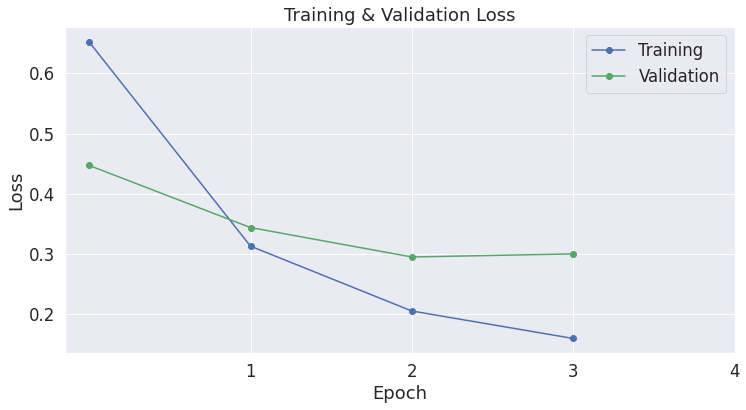

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot([it['Training Loss'] for it in training_stats], 'b-o', label="Training")
plt.plot([it['Valid. Loss'] for it in training_stats], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

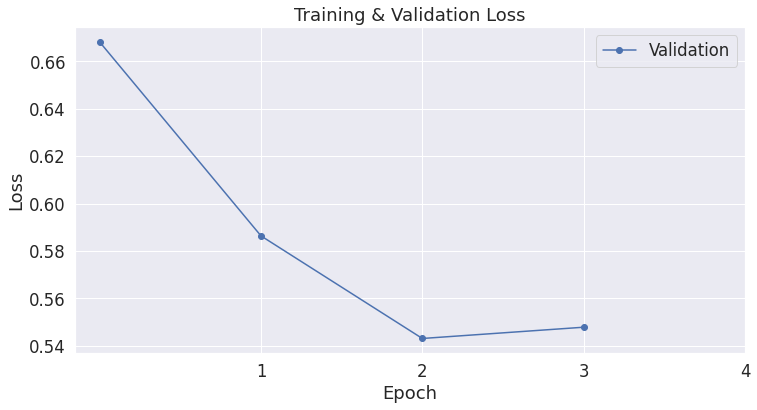

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot([it['Valid. RMSE.'] for it in training_stats], 'b-o', label="Validation")
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# sentences_val = val_data['text'].values
# labels_val = val_data['humor_rating'].values

In [ ]:
# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids_val_ = []
# attention_masks_val_ = []

# # For every sentence...
# for sent in sentences_val:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 32,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
    
#     # Add the encoded sentence to the list.    
#     input_ids_val_.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks_val_.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids_val_ = torch.cat(input_ids_val_, dim=0)
# attention_masks_val_ = torch.cat(attention_masks_val_, dim=0)
# labels_val_ = torch.tensor(labels_val)

# batch_size = 32  

# # Create the DataLoader.
# prediction_data = TensorDataset(input_ids_val_, attention_masks_val_, labels_val_)
# prediction_sampler = SequentialSampler(prediction_data)
# prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
len(prediction_dataloader)
len(prediction_data)

1000

In [ ]:
# # Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# # Put model in evaluation mode
# model.eval()

# # Tracking variables 
# predictions , true_labels = [], []

# # Predict 
# for batch in prediction_dataloader:
#   # Add batch to GPU
#   batch = tuple(t.to(device) for t in batch)
  
#   # Unpack the inputs from our dataloader
#   b_input_ids, b_input_mask, b_labels = batch
  
#   # Telling the model not to compute or store gradients, saving memory and 
#   # speeding up prediction
#   with torch.no_grad():
#       # Forward pass, calculate logit predictions.
#       result = model(b_input_ids, 
#                      token_type_ids=None, 
#                      attention_mask=b_input_mask,
#                      return_dict=True)

#   logits = result.logits

#   # Move logits and labels to CPU
#   logits = logits.detach().cpu().numpy()
#   label_ids = b_labels.to('cpu').numpy()
  
#   # Store predictions and true labels
#   predictions.append(logits)
#   true_labels.append(label_ids)

# print('    DONE.')

Predicting labels for 7,000 test sentences...
    DONE.


# is Humor or not? (base on threshold)

In [ ]:
def is_humor(score_humor):
  threshold = 1.0
  if score_humor >= threshold:
    return 1
  else:
    return 0